## Kernel Galerkin

This notebook is for playing around with the kernel galerkin method, trying it out for a specific case and visualization

In [2]:
import sys
import os

project_root = os.path.abspath("..")  # If notebooks is one folder above src
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [3]:
import numpy as np
import pandas as pd
import ipywidgets as widgets
import torch
from matplotlib import pyplot as plt
from tqdm import tqdm
from src.eigensolver.galerkin.galerkin_eigensolver import GalerkinSolver
from src.energy.quadratic import QuadraticEnergy
from src.energy.gaussian_mixture import GaussianMixture
from src.eigensolver.galerkin.kernel_basis import KernelBasis
from src.eigensolver.galerkin.constant_basis import ConstantBasis
from src.eigensolver.galerkin.orthogonal_basis import OrthogonalBasis
from src.eigensolver.galerkin.kernels.gaussian_kernel import GaussianKernel
from src.eigensolver.galerkin.kernels.polynomial_kernel import PolynomialKernel
from src.metrics.eigen_evaluator import EigenEvaluator
from src.metrics.pde_evaluator import ExactPDEEvaluator
from src.metrics.reconstruction_evaluator import ReconstructionEvaluator

from src.pdesolver.exact_solver import ExactEigenSolver
from src.pdesolver.fitted_solver import FittedEigenSolver

In [4]:
def kernel_experiment(experiment_params, energy, kernel_class = GaussianKernel):
    kernel_params = experiment_params['kernel_params']
    solver_params = experiment_params['solver_params']

    np.random.seed(42)
    dim = kernel_params['dim']
    x = energy.exact_sample((1000000,))

    kernel = kernel_class(kernel_params)

    p = kernel_params['p']
    L_reg = solver_params['L_reg']
    k = solver_params['k']
    
    basis_points = energy.exact_sample((p,))
    basis = KernelBasis(kernel, basis_points)
    basis = ConstantBasis(basis)

    solver = GalerkinSolver(energy, x, solver_params)

    solver = solver.fit(basis,k=min(p-1,k),L_reg=L_reg)

    return x, solver

### 1D Experiment

In [68]:
metrics = ['eigen_error',
           'orth_error',
           'eigen_cost', 
           'eigenvalue_mse',
           'eigenfunc_mse', 
           "fitted_eigenvalue_mse"]

experiment_params = {
    'kernel_params': {
        'dim': 1,
        'p': 100,
        'scale': 2.0,
        'order': 3
    },
    'solver_params': {
        'regularizer': 0.0,
        'L_reg': 1e-6,
        'verbose': False,
        'k': 6,
        'num_samples': 100000
    }
}

energy = QuadraticEnergy(np.eye(experiment_params['kernel_params']['dim']))

x, solver = kernel_experiment(experiment_params, energy, GaussianKernel)

if solver is None:
    print('Error')
else:
    evaluator = EigenEvaluator(energy)
    x_eval = energy.exact_sample((100000,))

    out = evaluator.evaluate_metrics(solver, x_eval, metrics, k = experiment_params['solver_params']['k'])
    for metric in metrics:
        print(f'{metric}: {out[metric]}')

eigen_error: [1.02952232e-07 2.35153690e-03 2.78935282e-03 5.93230529e-02
 6.99673275e-02 9.87530954e-01]
orth_error: [3.24869812e-13 1.05231968e-04 2.96089992e-04 3.35037579e-04
 1.08126799e-03 1.12156577e-03]
eigen_cost: [1.33997742e-08 1.01004087e+00 3.01673909e+00 6.10600125e+00
 1.01091239e+01 1.57958193e+01]
eigenvalue_mse: [9.63638140e-13 6.63959010e-05 6.73536728e-05 6.79765127e-03
 6.10092238e-03 1.06719188e+00]
eigenfunc_mse: [3.58570454e-09 2.56523128e-04 7.56180674e-04 1.52679956e-02
 1.74416560e-02 1.11635235e-01]
fitted_eigenvalue_mse: [9.60635019e-13 8.36459126e-08 1.00026450e-06 1.28789876e-03
 1.04132893e-03 7.87936452e-02]


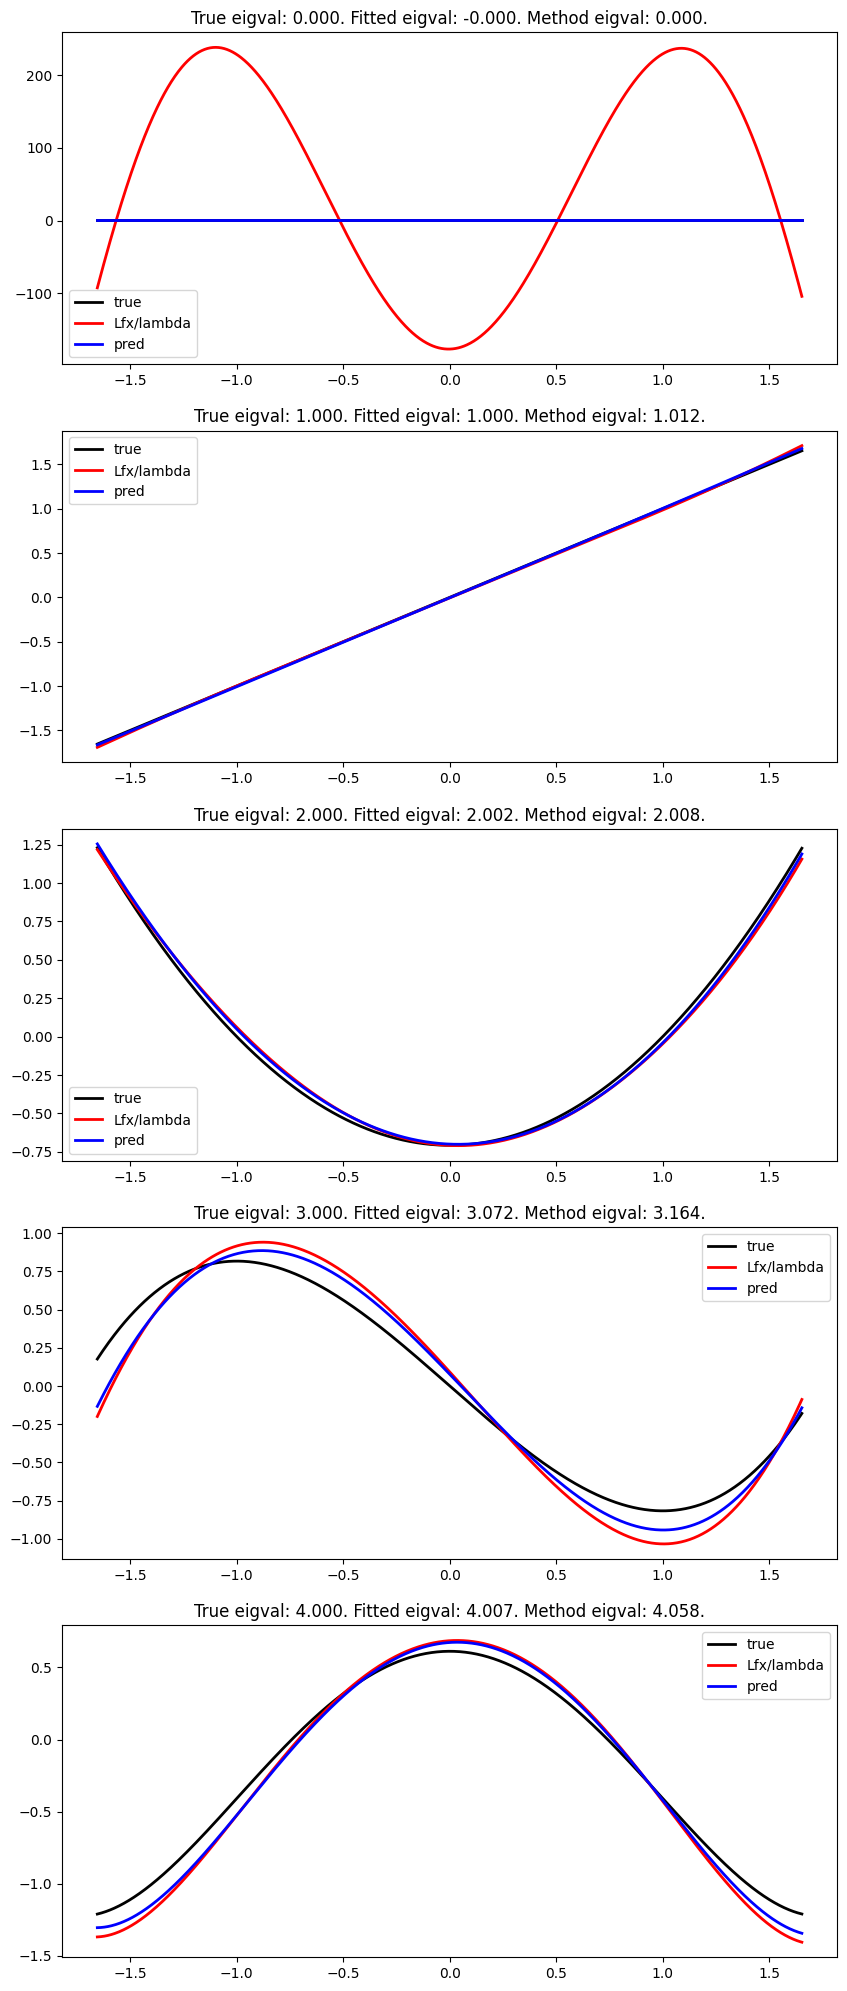

In [19]:
_ = evaluator.plot(solver,x_eval,5,plot_exact=True, plot_Lf = True)

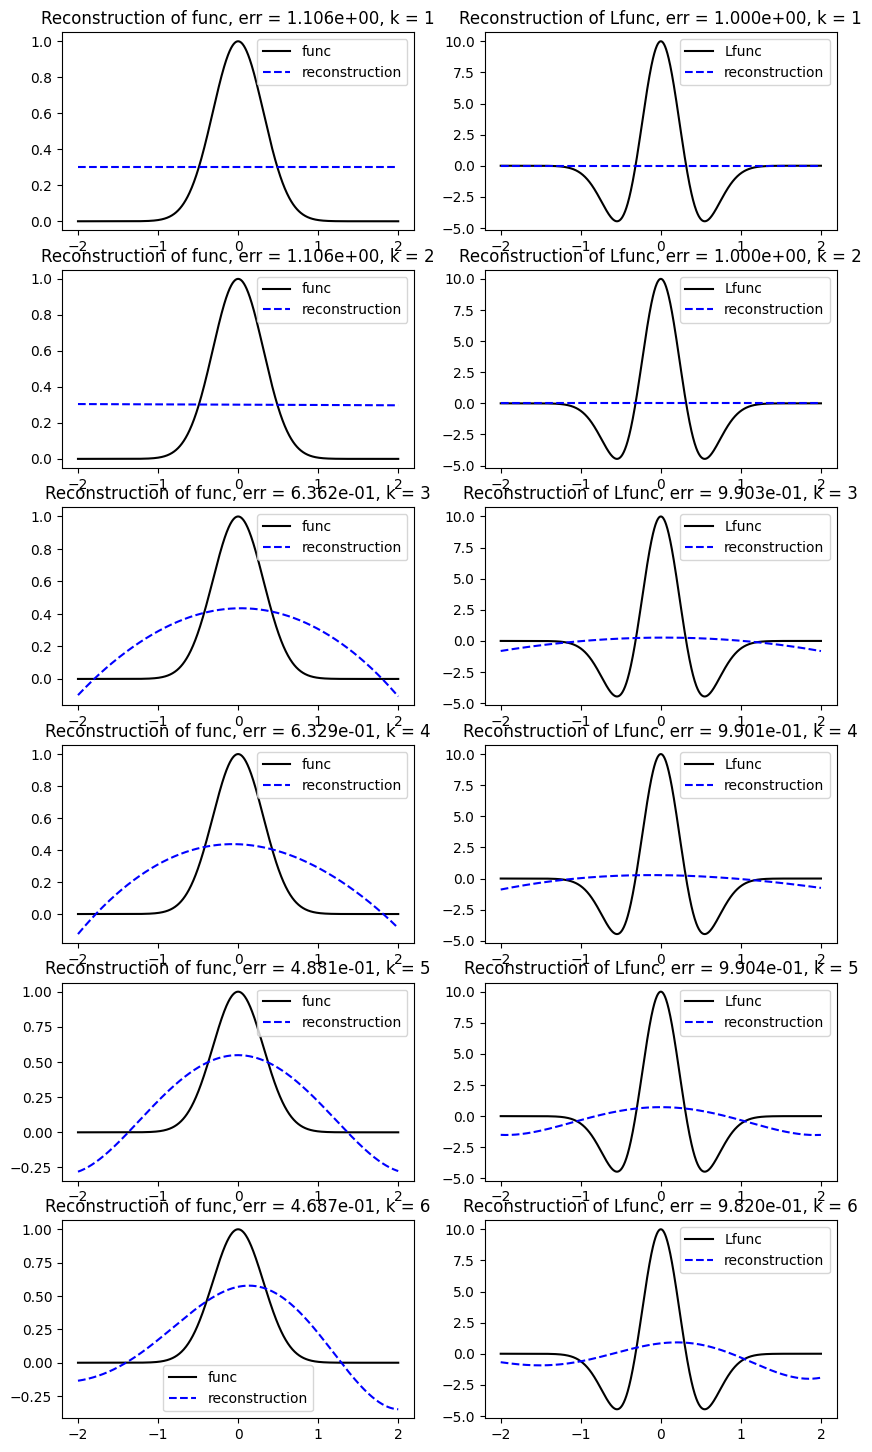

In [71]:
def func(x):
    return (1+x+x**2/2+x**3/6+x**4/24).sum()

def bad_func(x):
    return (-x**2*5).sum().exp()

reconstruction_evaluator = ReconstructionEvaluator(energy, bad_func)

t = np.linspace(-2,2,1000)[:,None]

_ = reconstruction_evaluator.plot_reconstruction(t, solver.predict(t),
                                             x, solver.predict(x),
                                             solver.fitted_eigvals)

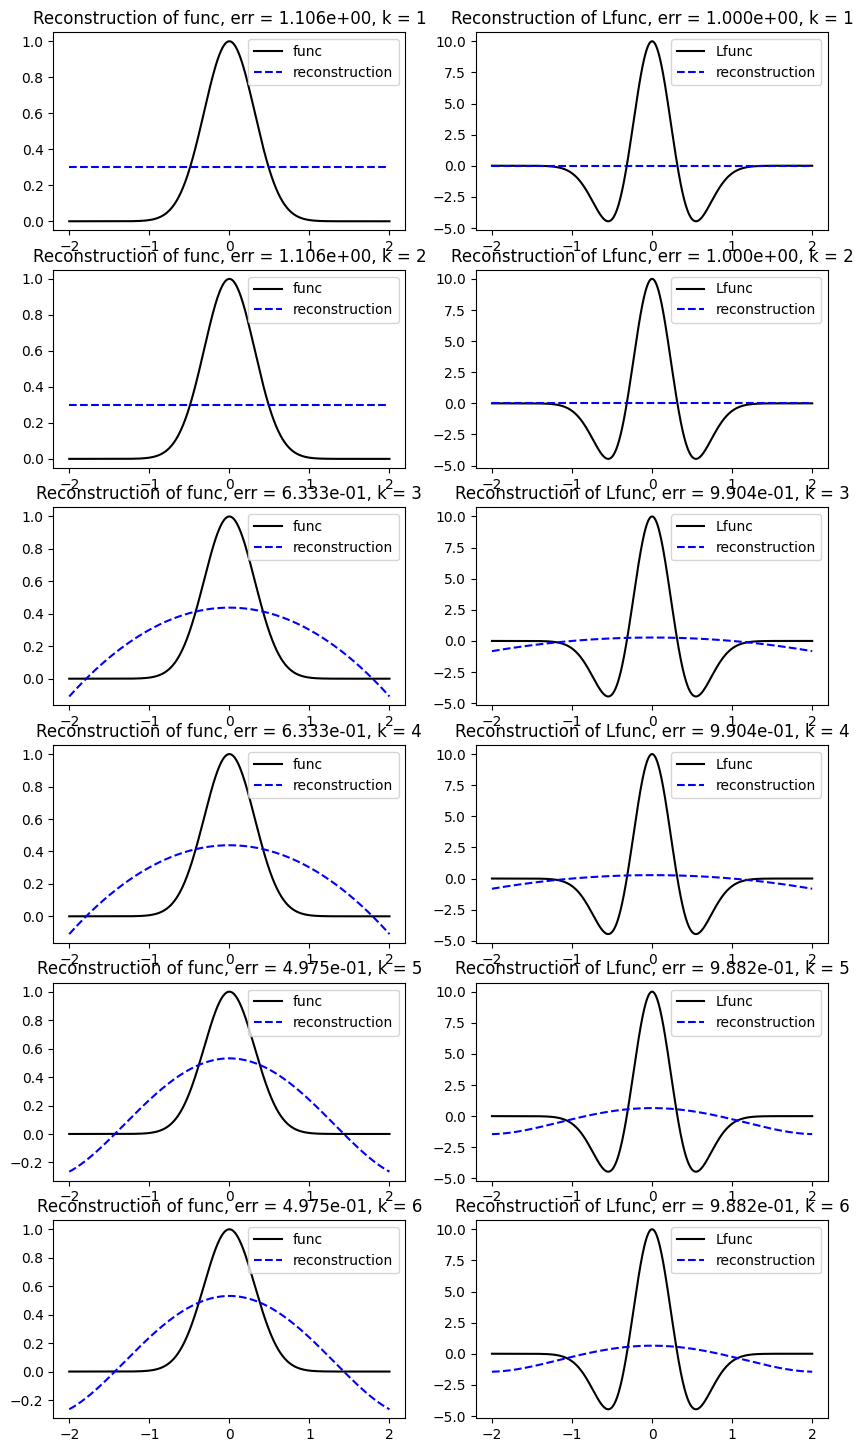

In [74]:
k = 6
_ = reconstruction_evaluator.plot_reconstruction(t, energy.exact_eigfunctions(t,k),
                                             x, energy.exact_eigfunctions(x,k),
                                             energy.exact_eigvals(k))

In [44]:
samples = energy.exact_sample((100000,))

fitted_solver = FittedEigenSolver(energy, samples, solver)
inner_prods = np.array([1,1,1,1])

def func(x_batch):
    return inner_prods@(energy.exact_eigfunctions(x_batch,len(inner_prods))).T

def exact_sol_func(x_batch, t):
    return np.sum(inner_prods[:,None,None] *
                np.exp(-energy.exact_eigvals(len(inner_prods))[:,None,None]*t[None,None,:]) * 
                (energy.exact_eigfunctions(x,len(inner_prods)).T)[:,:,None],axis=0)

T = 2000
t_max = 2
t = np.linspace(0,t_max,T)
x = np.linspace(-2,2,1000)[:,None]
k = 5

fitted_sol = fitted_solver.solve(func, t, x, k)
exact_sol = exact_sol_func(x, t)

pde_evaluator = ExactPDEEvaluator(energy, fitted_solver)

In [45]:
def plot_sol(time,k):
    i = int(time/t_max*T)
    plt.plot(x, exact_sol[:,i],label='exact solution',color='red')
    plt.plot(x, fitted_sol[k-1,:,i],label='fitted solution',color='blue')

    mse = np.mean((exact_sol[:,i] - fitted_sol[k-1,:,i])**2)
    plt.plot(x, func(x),label='intial value',color='black',ls='--')
    plt.ylim(-3,5)
    plt.title(f'MSE = {mse:.2e}')
    plt.legend()

widgets.interact(plot_sol, time = widgets.FloatSlider(min=0,max=t_max-t_max/T,step=t_max/T), k = widgets.IntSlider(min=1,max=k))

interactive(children=(FloatSlider(value=0.0, description='time', max=1.999, step=0.001), IntSlider(value=1, de…

<function __main__.plot_sol(time, k)>

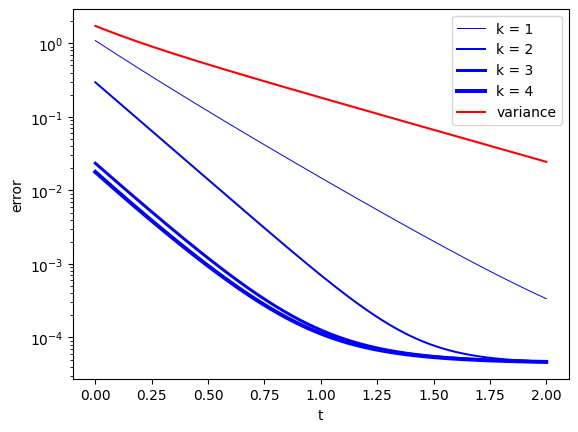

In [49]:
for k_fit in range(1,k):
    plt.plot(t,(np.mean((fitted_sol - exact_sol[None,:,:])**2,axis=1))[k_fit], label = f'k = {k_fit}', color='blue', lw = k_fit/1.4)

plt.plot(t,np.var(exact_sol,axis=0),label='variance', color='red')
plt.legend()
plt.ylabel('error')
plt.xlabel('t')
#plt.plot((np.mean((fitted_sol - exact_sol[None,:,:])**2,axis=1) / np.var(exact_sol, axis=0)[None,:])[k_fit])
plt.yscale('log')

### 2D Experiment

In [51]:
metrics = ['eigen_error','orth_error','eigen_cost', 'eigenvalue_mse','eigenfunc_mse', "fitted_eigenvalue_mse"]
experiment_params = {
    'kernel_params': {
        'dim': 2,
        'p': 150,
        'scale': 3.0,
        'order': 3
    },
    'solver_params': {
        'regularizer': 0.0,
        'L_reg': 1e-6,
        'verbose': False,
        'k': 6,
        'num_samples': 100000
    }
}

A = np.diag([1,0.25])

energy = QuadraticEnergy(A)

x, solver = kernel_experiment(experiment_params, energy, GaussianKernel)

if solver is None:
    print('Error')
else:
    evaluator = EigenEvaluator(energy)
    x_eval = energy.exact_sample((10000,))

    out = evaluator.evaluate_metrics(solver, x_eval, metrics, k = experiment_params['solver_params']['k'])
    for metric in metrics:
        print(f'{metric}: {out[metric]}')

eigen_error: [8.96150752e-09 1.46028262e-03 5.97883404e-03 1.42226338e-02
 1.23109760e-02 3.08156042e-02]
orth_error: [6.76754141e-13 4.32981626e-05 1.06193867e-04 2.34441553e-04
 1.61886805e-04 5.26483014e-04]
eigen_cost: [3.08113670e-09 2.52446695e-01 7.57125868e-01 1.55273297e+00
 2.55480255e+00 3.66230779e+00]
eigenvalue_mse: [9.92250968e-13 4.95396415e-06 1.68070440e-05 8.26059338e-04
 6.62988381e-04 3.37934416e-03]
eigenfunc_mse: [1.40115375e-09 5.88328092e-04 1.82673963e-03 1.37606733e-02
 2.99572786e-02 2.52861575e-02]
fitted_eigenvalue_mse: [3.09784125e-13 5.08319164e-06 4.34533978e-05 1.15261087e-03
 9.23073460e-04 4.11962123e-03]


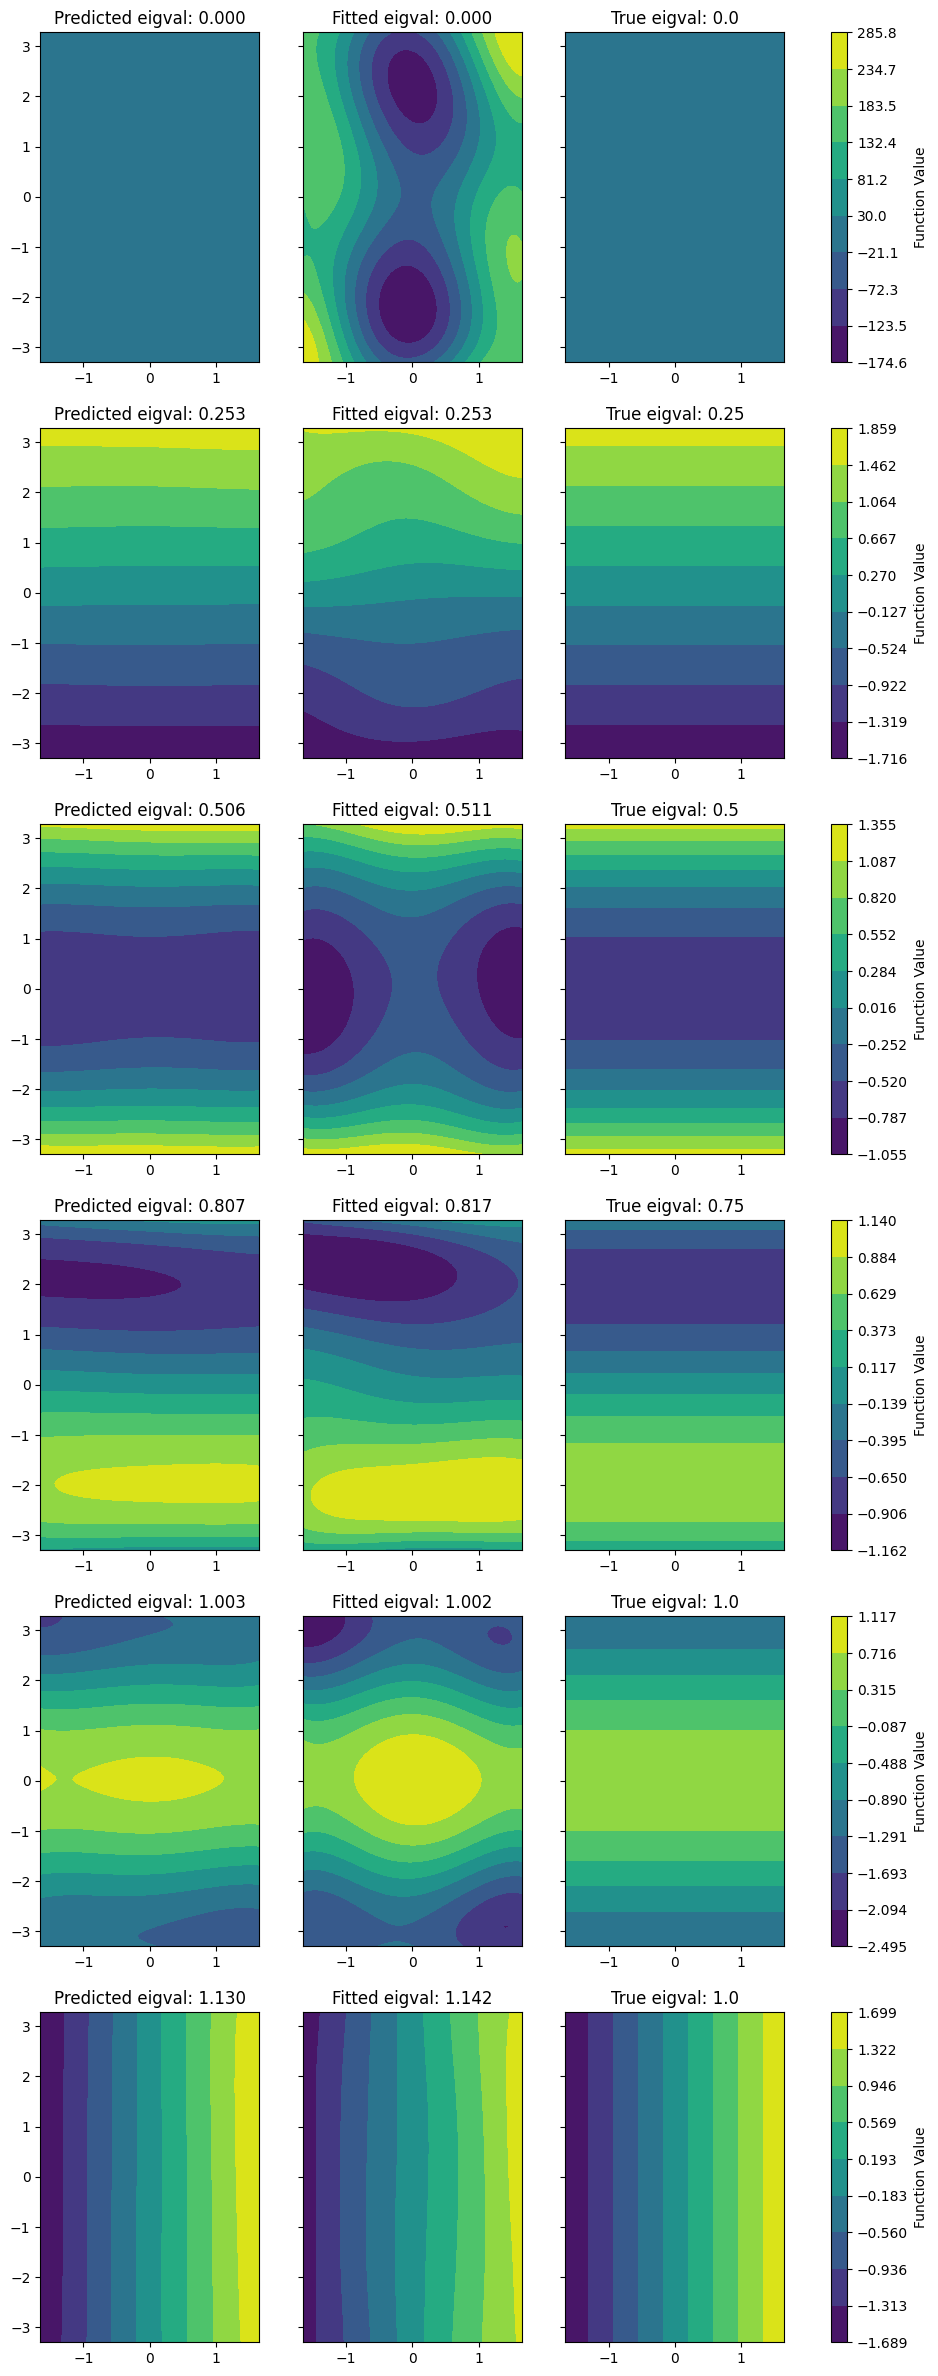

In [52]:
_ = evaluator.plot(solver,x_eval,6,plot_Lf=True,plot_exact=True)

## Gaussian Mixture

In [53]:
metrics = ['eigen_error','orth_error','eigen_cost', 'fitted_eigen_error']

dim = 2

experiment_params = {
    'kernel_params': {
        'dim': dim,
        'p': 200,
        'scale': 5.0,
        'order': 3
    },
    'solver_params': {
        'regularizer': 0.0,
        'L_reg': 1e-6,
        'verbose': False,
        'k': 50,
        'num_samples': 25_000
    }
}

#means = np.array([np.zeros(dim),np.zeros(dim)])
#covs = np.array([np.diag(0.5+np.random.random(dim)),np.diag(0.5+np.random.random(dim))])

means = np.array([[0,0],[2,2]])
covs = np.array([[[1,0],[0,1]], [[1,0],[0,1]]])

#means = np.array([[0], [5]])
#covs = np.array([[[1]], [[1]]])
w = np.array([0.9,0.1])

energy = GaussianMixture(w,means,covs)
x, solver = kernel_experiment(experiment_params, energy, GaussianKernel)

if solver is None:
    print('Error')
else:
    evaluator = EigenEvaluator(energy)
    x_eval = energy.exact_sample((10000,))

    out = evaluator.evaluate_metrics(solver, x_eval, metrics, k = experiment_params['solver_params']['k'])
    for metric in metrics:
        print(f'{metric}: {out[metric]}')

eigen_error: [9.38104179e-08 9.89508862e-02 6.80635115e-02 9.92774705e-02
 1.19004175e-01 1.01396131e-01 1.36406194e-01 1.71741352e-01
 2.27084597e-01 8.62534629e-01 5.73234272e+00 5.26548738e+03
 2.80750856e+04 3.37172082e+05 1.81363311e+06 3.93061640e+09
 9.36108328e+09 2.22405103e+10 6.71332151e+10 2.15298384e+11
 2.14951971e+11 2.15115626e+11 2.34641390e+11 2.27308019e+11
 2.25548633e+11 2.19028544e+11 2.11701468e+11 2.06210616e+11
 2.00153399e+11 2.10289444e+11 2.06380812e+11 2.01219124e+11
 1.95614706e+11 1.92017789e+11 1.90556831e+11 2.01470861e+11
 1.97197502e+11 1.94847188e+11 1.91094903e+11 1.99819789e+11
 1.95858271e+11 1.95030841e+11 1.91163184e+11 1.88082703e+11
 1.86109336e+11 1.85239835e+11 1.81810797e+11 1.83711296e+11
 1.83151019e+11 1.81744114e+11]
orth_error: [8.63214415e-13 1.58607600e-04 1.22314043e-04 8.95930443e-05
 1.17348151e-04 1.90519383e-04 2.52481519e-04 2.49086299e-04
 1.00421419e-03 1.14153130e-03 1.09866119e-03 1.35949150e-03
 1.22272354e-03 1.33014765e-

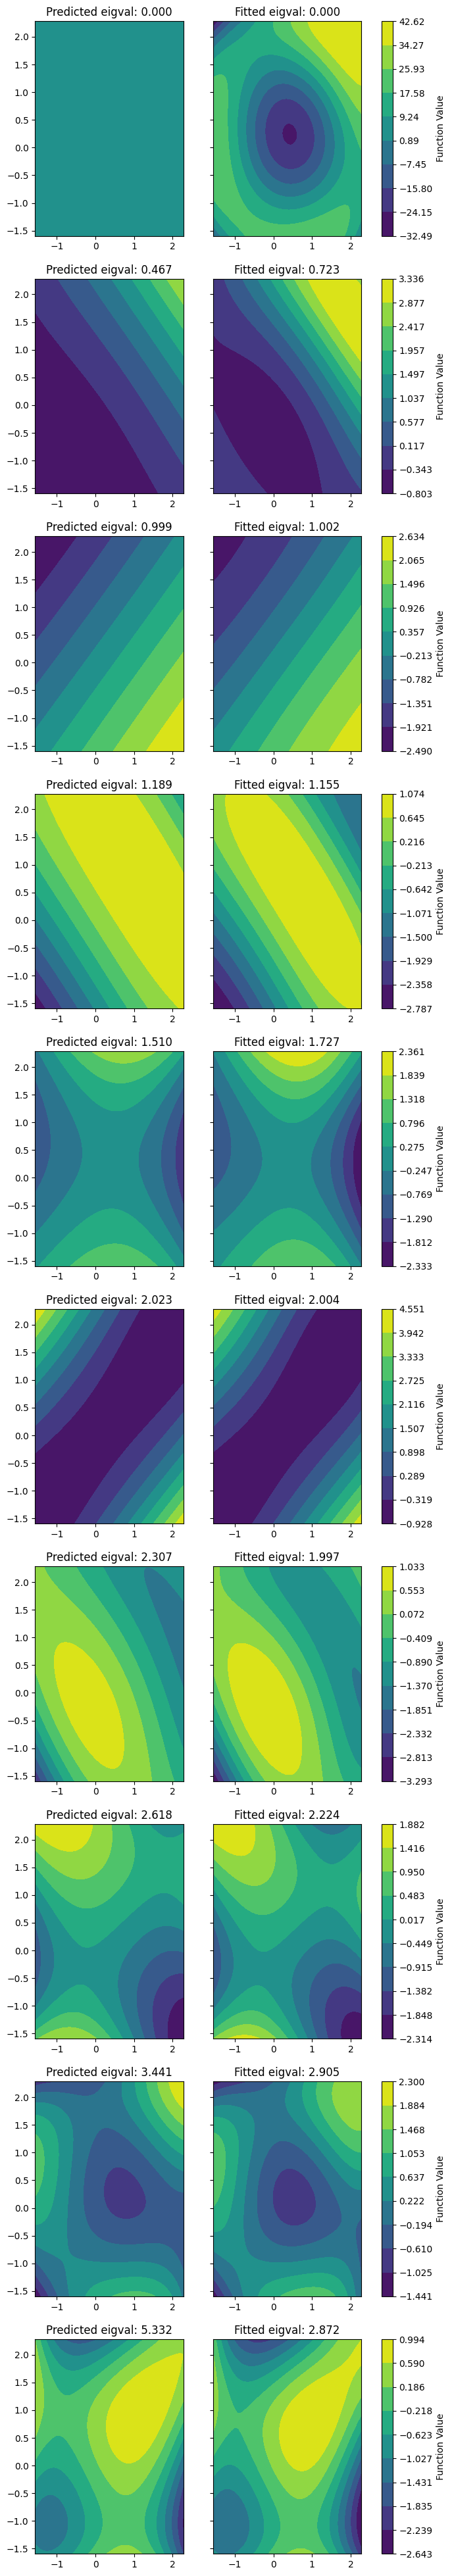

In [54]:
_ = evaluator.plot(solver,x_eval,10,plot_Lf=True)

In [65]:
def func(x):
    return (x**3).sum()

reconstruction_evaluator = ReconstructionEvaluator(energy, func)

errs = reconstruction_evaluator.compute_reconstruction_error(x, solver.predict(x),
                                             x, solver.predict(x),
                                             solver.fitted_eigvals)

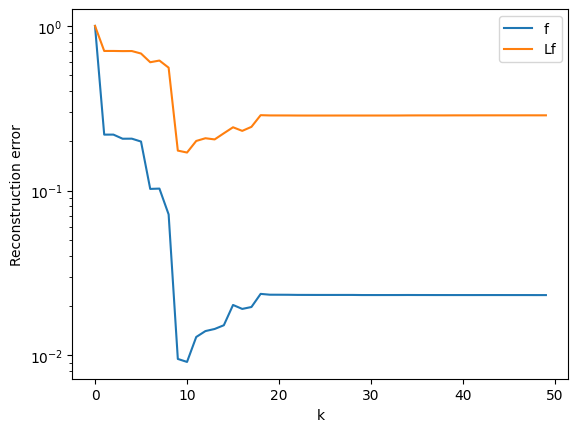

In [66]:
plt.plot(errs[0],label = 'f')
plt.plot(errs[1],label = 'Lf')
plt.yscale('log')
plt.ylabel('Reconstruction error')
plt.xlabel('k')
plt.legend()

## PDE

In [60]:
def plot_sol(time):
    i = int(time/t_max*T)
    plt.plot(x, sol[:,i],label='exact solution',color='red')
    plt.plot(x, fitted_sol[:,i],label='fitted solution',color='blue')

    plt.plot(x, func(x),label='intial value',color='black',ls='--')
    #plt.ylim(-3,5)
    plt.legend()

widgets.interact(plot_sol, time = widgets.FloatSlider(min=0,max=t_max-t_max/T,step=t_max/T))

interactive(children=(FloatSlider(value=0.0, description='time', max=4.995, step=0.005), Output()), _dom_class…

<function __main__.plot_sol(time)>

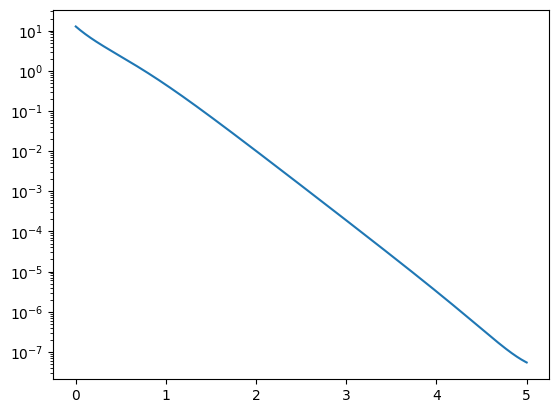

In [61]:
plt.plot(t,np.mean((sol - fitted_sol)**2,axis=0)/np.mean(sol**2,axis=0))
plt.yscale('log')

In [59]:
from scipy.special import eval_hermitenorm

In [64]:
sample_fx = func(samples)

In [78]:
energy = QuadraticEnergy(np.eye(2))
samples = energy.exact_sample((100000,))

In [50]:
fx = solver.predict(samples)

In [51]:
np.mean(fx*fx,axis=0)

array([0.99999992, 1.0125418 , 1.02972332, 1.04808389, 1.04084128])

In [62]:
np.mean(fitted_solver.sample_fx*fitted_solver.sample_funcx[:,None],axis=0)

array([ 1.10795158e-03,  1.51219171e-02, -1.44077040e+00])

In [63]:
inner_prods

array([ 0.01596373,  0.03065979, -1.46722702,  0.13098053])

## Scratch work

In [13]:
# reconstruct |x|^2

x = energy.exact_sample((100000,))
k = 200
eigfuncs = solver.predict(x)
weights = np.array([0]*19 + [1])
func = lambda x: 1/2*np.sum(x**2,axis=1)
fx = func(x)
Lfx = np.sum(energy.grad(x) * x,axis=1) - energy.dim

In [14]:
inner_prods = np.sum(fx[:,None]*eigfuncs,axis=0)/x.shape[0]

In [15]:
errs = []
L_errs = []

for i in range(1,k+1):
    errs.append(1-np.mean((fx - inner_prods[:i]@(eigfuncs[:,:i]).T)**2)/np.mean((func(x) - np.mean(func(x)))**2))
    L_errs.append(1-np.mean((Lfx - (solver.fitted_eigvals[:i]*inner_prods[:i])@(eigfuncs[:,:i]).T)**2)/np.mean(Lfx**2))

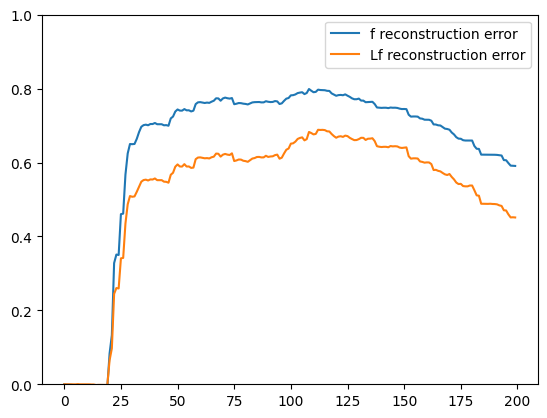

In [16]:
plt.plot(errs, label = 'f reconstruction error')
plt.plot(L_errs, label = 'Lf reconstruction error')

plt.ylim(0,1)
plt.legend()

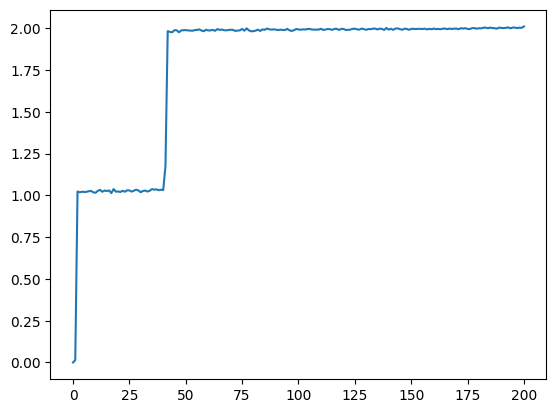

In [347]:
plt.plot(solver.fitted_eigvals, label = 'eigvals')

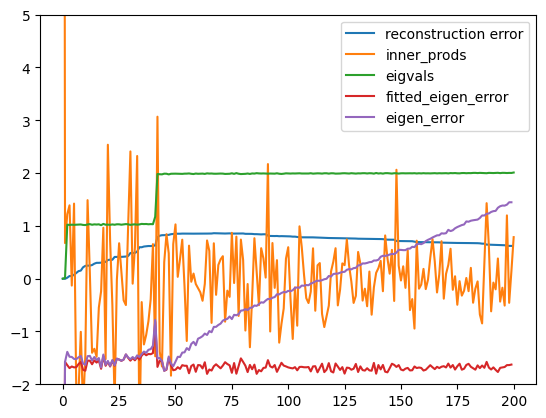

In [348]:
plt.plot(errs, label = 'reconstruction error')
plt.plot(inner_prods, label = 'inner_prods')
plt.plot(solver.fitted_eigvals, label = 'eigvals')
plt.plot(np.log10(out['fitted_eigen_error']),label = 'fitted_eigen_error')
plt.plot(np.log10(out['eigen_error']),label = 'eigen_error')

plt.ylim(-2,5)
plt.legend()

In [149]:
np.mean((func(x) - inner_prods@eigfuncs.T)**2)

np.float64(0.4760264414619271)

In [150]:
np.mean((func(x) - np.mean(func(x)))**2)

np.float64(1.219519479477328)

In [151]:
1-np.mean((func(x) - inner_prods@eigfuncs.T)**2)/np.mean((func(x) - np.mean(func(x)))**2)

np.float64(0.6096606495650676)

### Hyperparameter experiment

In [ ]:

for kernel_scale in tqdm(kernel_scales):
    for p in ps:
        #x, solver = polynomial_kernel_experiment(dim, p, kernel_scale, kernel_order=kernel_order)
        x, solver = gaussian_kernel_experiment(dim, p, kernel_scale)
        
        if solver is not None:
            eigen_errs.append(eigen_error(x,solver,k))
            orth_errs.append(orth_error(x,solver,k))
            L_prod_errs.append(L_prod_error(x,solver,k))
        else:
            eigen_errs.append(np.nan)
            orth_errs.append(np.nan)
            L_prod_errs.append(np.nan)

eigen_errs = np.array(eigen_errs).reshape((len(kernel_scales),len(ps)))
orth_errs = np.array(orth_errs).reshape((len(kernel_scales),len(ps)))
L_prod_errs = np.array(L_prod_errs).reshape((len(kernel_scales),len(ps)))

Text(0, 0.5, 'kernel scale')

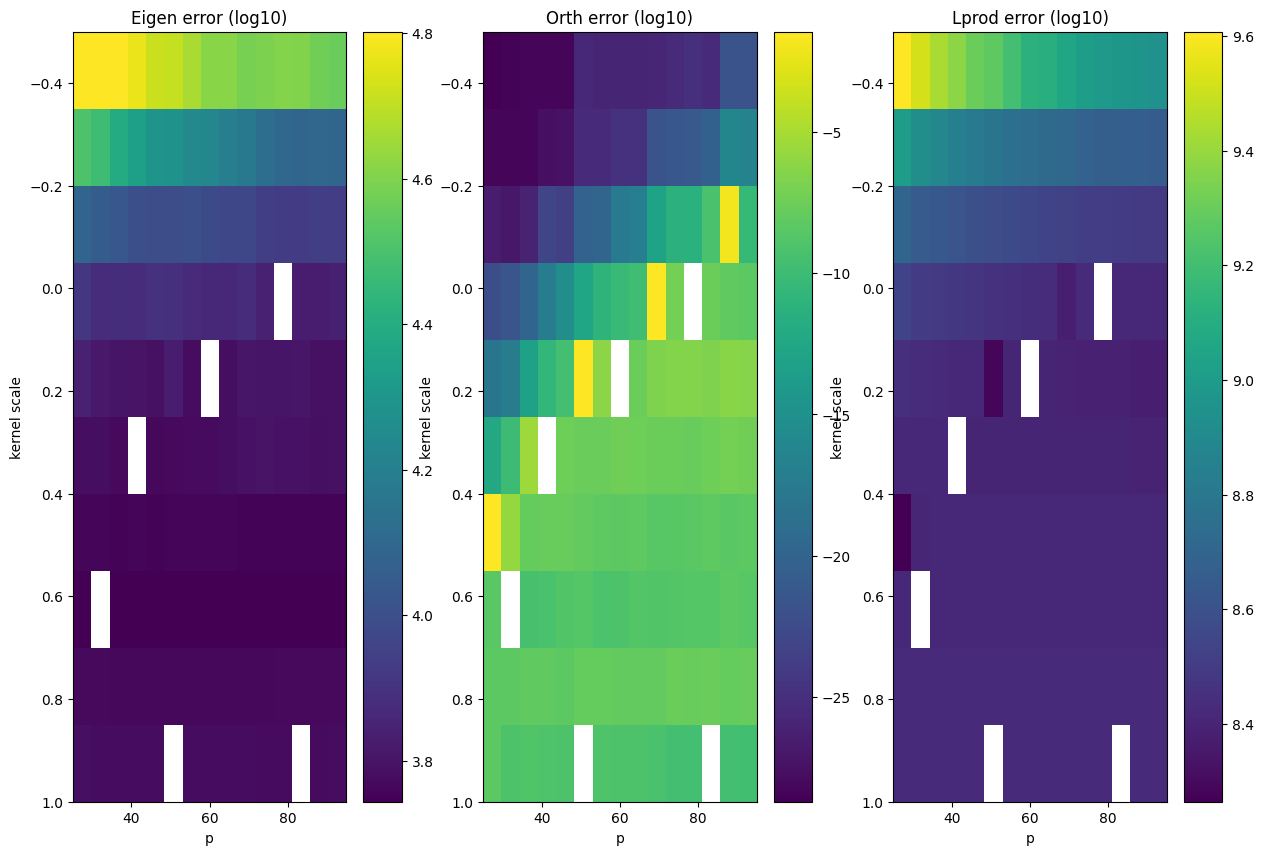

In [31]:
fig, ax = plt.subplots(1,3,figsize=(15,10))

cax = ax[0].imshow(np.log10(eigen_errs),extent=(ps[0],ps[-1],np.log10(kernel_scales[-1]),np.log10(kernel_scales[0])),aspect='auto')
cbar = fig.colorbar(cax, ax=ax[0],shrink=1)
ax[0].set_title('Eigen error (log10)')

cax = ax[1].imshow(np.log10(orth_errs),extent=(ps[0],ps[-1],np.log10(kernel_scales[-1]),np.log10(kernel_scales[0])),aspect='auto')
cbar = fig.colorbar(cax, ax=ax[1],shrink=1)
ax[1].set_title('Orth error (log10)')

cax = ax[2].imshow(np.log10(L_prod_errs),extent=(ps[0],ps[-1],np.log10(kernel_scales[-1]),np.log10(kernel_scales[0])),aspect='auto')
cbar = fig.colorbar(cax, ax=ax[2],shrink=1)
ax[2].set_title('Lprod error (log10)')

ax[0].set_xlabel('p')
ax[0].set_ylabel('kernel scale')
ax[1].set_xlabel('p')
ax[1].set_ylabel('kernel scale')
ax[2].set_xlabel('p')
ax[2].set_ylabel('kernel scale')

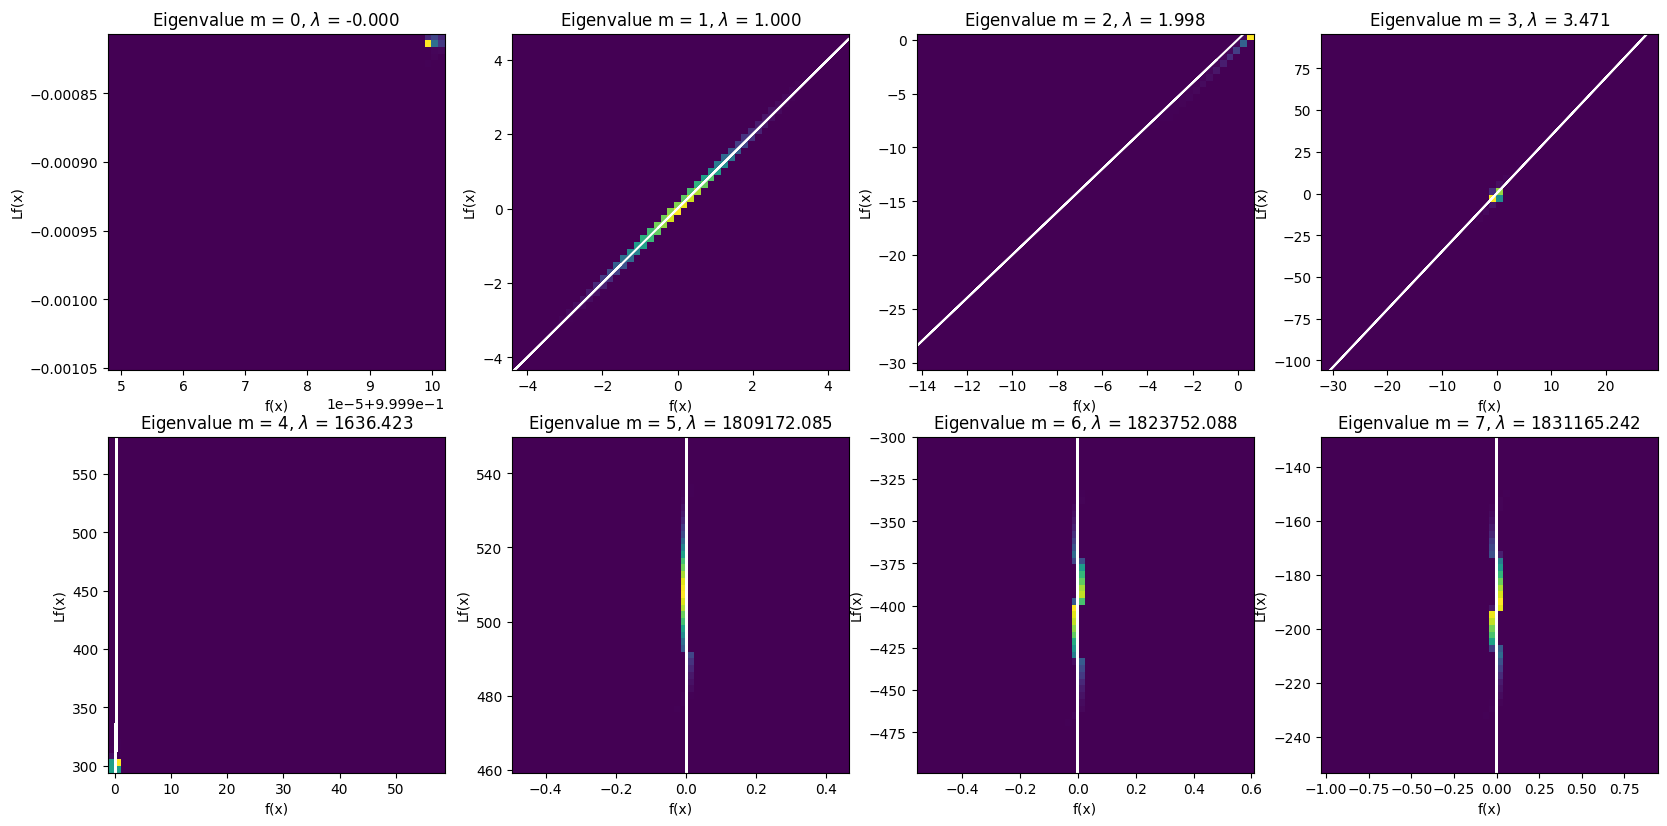

In [64]:
plot_eigenfunctions(x,solver,8)

In [12]:
grad = np.random.standard_normal((1000,100,10))

In [8]:
from itertools import product
import numpy as np

arrays = [np.array([1, 2]), np.array([3, 4]), [5]]
cartesian_product = np.array(list(product(*arrays)))

In [1]:
a = {'b': 1}
c = {'d': 4}

In [8]:
import numpy as np

In [9]:
class TestClass():
    def __init__(self, rng):
        self.rng = np.random.default_rng(rng)

    def random_number(self):
        print(self.rng.random(1))

In [16]:
rng = np.random.default_rng(32)

In [19]:
2**15

32768

In [12]:
means = np.array([[0,0],[1,0]])
covs = np.array([np.eye(2),np.eye(2)])
w = np.array([0.5,0.5])

energy = GaussianMixture(w,means,covs)

AttributeError: 'numpy.ndarray' object has no attribute 'dim'

In [7]:
sample = np.random.multivariate_normal(np.zeros(2), A, size = 10)
        

In [8]:
sample

array([[-1.03591711e+00, -4.38469364e-01],
       [-1.20226348e+00, -5.02518805e-01],
       [-5.90221913e-01, -6.32865982e-01],
       [-1.03081200e-01, -8.50193181e-01],
       [-1.50020486e-01, -3.26154397e-04],
       [ 2.65191361e-01,  9.31788362e-02],
       [ 9.81780193e-01,  2.54230429e-01],
       [ 1.67686907e+00,  3.78149627e-02],
       [-6.33384107e-01, -4.11349989e-01],
       [-1.98442068e-02, -2.65256227e-01]])